# Replicate Fig7D from Rees et al 2016


In [8]:
# from igraph import *
# from bluepy.enums import Cell
from scipy import sparse
import bluepy
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import logging
from graph_analysis.triplets import MotifReader, CA1MotifCalculator

import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
from graph_analysis import triplets
import pickle 


In [2]:
all_motifs = ['-C','-B','-A','A','B','C','D','E','F','G','H','I','J','K','L','M']
save_dir = '../../output/triplets'
nodeset = 'cylinder300'

In [3]:
complex_motif = Motif("""
# One-direction edge
uniedge(n, m) {
    n -> m
    m !> n
}

# One-direction triangle
unitriangle(x, y, z) {
    uniedge(x, y)
    uniedge(y, z)
    uniedge(z, x)
}

unitriangle(A, B, C)
""") # specific case not like motif2 where edges can also be biedge/uniedge

In [4]:
file_path = '/gpfs/bbp.cscs.ch/project/proj142/home/kurban/GNNplayground/notebooks/cylinder300_synaptome.npz'
target_adj = sparse.load_npz(file_path)

In [5]:
from bluepysnap import Circuit

c = Circuit('/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/sonata/circuit_config.json')
nodes = c.nodes['hippocampus_neurons']

In [6]:
c.node_sets.content.keys()

dict_keys(['All', 'Excitatory', 'Cylinder300', 'Inhibitory', 'SLM_PPA', 'SO_BP', 'SO_BS', 'SO_OLM', 'SO_Tri', 'SP_AA', 'SP_BS', 'SP_CCKBC', 'SP_Ivy', 'SP_PC', 'SP_PVBC', 'SR_SCA', 'bAC', 'cAC', 'cACpyr', 'cNAC', 'SLM', 'SO', 'SP', 'SR', 'BC', 'BS', 'CCK', 'PV', 'SOM', 'SP_INT', 'nonCCK', 'slice21', 'slice36', 'slice40', 'cylinder300_exc', 'slice8', 'slice41', 'slice4', 'target_single', 'slice33', 'cylinder300_inh', 'slice32', 'slice42', 'slice10', 'cylinder397485r300', 'Mosaic', 'slice19', 'cylinder253803r300', 'slice2', 'slice6', 'slice39', 'CA3_SP_PC', 'source_single', 'slice30', 'slice46', 'slice25', 'slice34', 'slice15', 'cylinder299049r300', 'slice12', 'cylinder300', 'slice16', 'slice27', 'cylinder109262r300', 'slice43', 'slice0', 'cylinder269358r300', 'slice26', 'CB1R_pos', 'slice14', 'slice7', 'source_cyl_unique', 'slice22', 'slice44', 'slice45', 'cylinder128660r300', 'slice38', 'slice37', 'slice29', 'slice28', 'cylinder329179r300', 'slice18', 'slice17', 'slice20', 'cylinders', 

In [13]:
nodeset_ids = nodes.ids(nodeset)

In [14]:
check_mtypes = ['Inhibitory','Inhibitory','Inhibitory']

In [15]:
assert len(np.unique(check_mtypes)) == 1

In [16]:
nodeset_subids = np.intersect1d(nodeset_ids,nodes.ids('Inhibitory')) # to be changed for each, union operator if multiple mtypes

In [17]:
local_indices_selected = np.where(np.isin(nodeset_ids,nodeset_subids))[0] # indices inside nodeset indices

In [18]:
subset_adj = target_adj[local_indices_selected,:][:,local_indices_selected]

In [19]:
subset_adj[subset_adj>1] = 1  # connectome

In [20]:
target_graph = nx.from_scipy_sparse_array(subset_adj,create_using=nx.DiGraph())

In [23]:
Executor = GrandIsoExecutor(graph=target_graph)

In [26]:
frequencies_inh = {}
motif_reader = triplets.MotifReader()
reader = triplets.DotMotifReader()

for motif_name in tqdm(all_motifs):
    logging.info(f"Running motif calculation for {nodeset} of motif {motif_name} of {check_mtypes}...")
    CM = motif_reader.name_to_matrix(motif_name)
    cur_triplet_motif = reader.matrix_to_dotmotif(CM)
    if cur_triplet_motif == '':
        continue
    else:
        logging.info(f"\n{CM} \n\n dotmotif:\n{cur_triplet_motif}\n\n")
        cur_triplet_motif = Motif(cur_triplet_motif)

    cur_results = Executor.find(cur_triplet_motif)
    frequencies_inh[motif_name] = cur_results

  0%|          | 0/16 [00:00<?, ?it/s]INFO:root:Running motif calculation for cylinder300 of motif -C of ['Inhibitory', 'Inhibitory', 'Inhibitory']...
INFO:root:Running motif calculation for cylinder300 of motif -B of ['Inhibitory', 'Inhibitory', 'Inhibitory']...
INFO:root:
[[0 1 0]
 [0 0 0]
 [0 0 0]] 

 dotmotif:
A -> B


 12%|█▎        | 2/16 [00:00<00:04,  2.96it/s]INFO:root:Running motif calculation for cylinder300 of motif -A of ['Inhibitory', 'Inhibitory', 'Inhibitory']...
INFO:root:
[[0 1 0]
 [1 0 0]
 [0 0 0]] 

 dotmotif:
A -> B
B -> A


 19%|█▉        | 3/16 [00:01<00:04,  2.73it/s]INFO:root:Running motif calculation for cylinder300 of motif A of ['Inhibitory', 'Inhibitory', 'Inhibitory']...
INFO:root:
[[0 0 0]
 [1 0 0]
 [1 0 0]] 

 dotmotif:
B -> A
C -> A


 25%|██▌       | 4/16 [04:23<19:36, 98.07s/it]INFO:root:Running motif calculation for cylinder300 of motif B of ['Inhibitory', 'Inhibitory', 'Inhibitory']...
INFO:root:
[[0 0 0]
 [1 0 0]
 [0 1 0]] 

 dotmotif:
B -> A
C -> 

In [33]:
#SAVE 

target_motifs_inh = {}
for i in all_motifs:
    try:
        cur_occurences = len(frequencies_inh[i])
        target_motifs_inh[i] = cur_occurences
    except:
        print(f'{i} not in frequencies')
        target_motifs_inh[i] = -1

-C not in frequencies


In [70]:

with open(f'{save_dir}/inhibitory_triplets_{nodeset}.pkl','wb') as f:
    pickle.dump(frequencies_inh,f)

In [9]:
with open(f'{save_dir}/inhibitory_triplets_{nodeset}.pkl','rb') as f:
    frequencies_inh = pickle.load(f)

In [23]:
304 in nodeset_subids

False

In [25]:
local_indices_selected

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26, 5563, 5564, 5565, 5566, 5567, 5568,
       5569, 5570, 5571, 5572, 5573, 5574, 5575, 5576, 5577, 5578, 5579,
       5580, 5581, 5582, 5583, 5584, 5585, 5586, 5587, 5588, 5589, 5590,
       5591, 5592, 5593, 5594, 5595, 5596, 5597, 5598, 5599, 5600, 5601,
       5602, 5603, 5604, 5605, 5606, 5607, 5608, 5609, 5610, 5611, 5612,
       5613, 5614, 5615, 5616, 5617, 5618, 5619, 5620, 5621, 5622, 5623,
       5624, 5625, 5626, 5627, 5628, 5629, 5630, 5631, 5632, 5633, 5634,
       5635, 5636, 5637, 5638, 5639, 5640, 5641, 5642, 5643, 5644, 5645,
       5646, 5647, 5648, 5649, 5650, 5651, 5652, 5653, 5654, 5655, 5656,
       5657, 5658, 5659, 5660, 5661, 5662, 5663, 5664, 5665, 5666, 5667,
       5668, 5669, 5670, 5671, 5672, 5673, 5674, 5675, 5676, 5677, 5678,
       5679, 5680, 5681, 5682, 5683, 5684, 5685, 56

In [30]:
target_graph.get_edge_data(1,8)

In [31]:
target_graph.get_edge_data(8,1)

{'weight': 1.0}

In [34]:
nodes.get(nodeset).iloc[1]

etype                                                                        bAC
layer                                                                        SLM
me_combo                       CA1_int_bAC_011127HP1_2019032911561_SLM_PPA_SL...
model_template                           hoc:CA1_int_bAC_011127HP1_2019032911561
model_type                                                           biophysical
morph_class                                                                  INT
morphology                                011127HP1_-_Scale_x1.000_y0.850_z1.000
mtype                                                                    SLM_PPA
orientation_w                                                           0.829968
orientation_x                                                           -0.14063
orientation_y                                                          -0.531963
orientation_z                                                          -0.091603
region                      

In [58]:
A_indices = [d['B'] for d in frequencies_inh['D']]
A_values = nodes.get(nodeset_ids[A_indices]).iloc[A_indices]['mtype']

In [64]:
np.unique(A_values,return_counts=True)

(array(['SLM_PPA', 'SP_PC', 'SR_SCA'], dtype=object),
 array([ 274330, 4817767,   85745]))

In [38]:
local_edges = c.edges[c.edges.population_names[1]]

In [43]:
nodeset_ids[8],nodeset_ids[1]

(246, 77)

In [42]:
list(local_edges.iter_connections(nodeset_ids[8],nodeset_ids[1],return_edge_count=True))

[(246, 77, 2)]

In [44]:
len(frequencies_inh['D'])

5177842

In [12]:
frequencies_inh['D']

[{'A': 1, 'B': 4, 'C': 8},
 {'A': 1, 'B': 4, 'C': 26},
 {'A': 1, 'B': 4, 'C': 304},
 {'A': 1, 'B': 4, 'C': 600},
 {'A': 1, 'B': 4, 'C': 614},
 {'A': 1, 'B': 4, 'C': 621},
 {'A': 1, 'B': 4, 'C': 622},
 {'A': 1, 'B': 4, 'C': 632},
 {'A': 1, 'B': 4, 'C': 634},
 {'A': 1, 'B': 4, 'C': 639},
 {'A': 1, 'B': 4, 'C': 643},
 {'A': 1, 'B': 4, 'C': 674},
 {'A': 4, 'B': 672, 'C': 1},
 {'A': 4, 'B': 672, 'C': 23},
 {'A': 4, 'B': 672, 'C': 114},
 {'A': 4, 'B': 672, 'C': 600},
 {'A': 4, 'B': 672, 'C': 614},
 {'A': 4, 'B': 672, 'C': 621},
 {'A': 4, 'B': 672, 'C': 622},
 {'A': 4, 'B': 672, 'C': 639},
 {'A': 4, 'B': 672, 'C': 643},
 {'A': 4, 'B': 672, 'C': 645},
 {'A': 4, 'B': 1, 'C': 23},
 {'A': 4, 'B': 1, 'C': 114},
 {'A': 4, 'B': 1, 'C': 600},
 {'A': 4, 'B': 1, 'C': 614},
 {'A': 4, 'B': 1, 'C': 621},
 {'A': 4, 'B': 1, 'C': 622},
 {'A': 4, 'B': 1, 'C': 639},
 {'A': 4, 'B': 1, 'C': 643},
 {'A': 4, 'B': 1, 'C': 645},
 {'A': 4, 'B': 1, 'C': 672},
 {'A': 7, 'B': 9, 'C': 18},
 {'A': 7, 'B': 9, 'C': 610},
 {

In [34]:
target_motifs_inh

{'-C': -1,
 '-B': 82212,
 '-A': 35082,
 'A': 12027662,
 'B': 11167323,
 'C': 12414160,
 'D': 5177842,
 'E': 4660246,
 'F': 5370309,
 'G': 3623334,
 'H': 2507828,
 'I': 2493918,
 'J': 2198322,
 'K': 2535490,
 'L': 1370615,
 'M': 877944}

In [54]:
target_motifs_exc = {'-C': -1,
 '-B': 555057,
 '-A': 10738,
 'A': 75188930,
 'B': 48277113,
 'C': 72068488,
 'D': 1170657,
 'E': 3339580,
 'F': 1285219,
 'G': 391599,
 'H': 107978,
 'I': 31840,
 'J': 33708,
 'K': 103664,
 'L': 2534,
 'M': 156}

In [66]:
nodes.get().iloc[0]

etype                                                                        bAC
layer                                                                        SLM
me_combo                       CA1_int_bAC_011127HP1_2019032911561_SLM_PPA_SL...
model_template                           hoc:CA1_int_bAC_011127HP1_2019032911561
model_type                                                           biophysical
morph_class                                                                  INT
morphology                                011127HP1_-_Scale_x1.000_y1.050_z1.000
mtype                                                                    SLM_PPA
orientation_w                                                           0.666266
orientation_x                                                           0.732591
orientation_y                                                           0.102982
orientation_z                                                          -0.093783
region                      

# CA1 PYR:INT

In [55]:
# nodeset_subids = np.intersect1d(nodeset_ids,nodes.ids('INT')) # to be changed for each, union operator if multiple mtypes
# local_indices_selected = np.where(np.isin(nodeset_ids,nodeset_subids))[0] # indices inside nodeset indices
# subset_adj = target_adj[local_indices_selected,:][:,local_indices_selected]
# subset_adj[subset_adj>1] = 1  # connectome
# target_graph = nx.from_scipy_sparse_array(subset_adj,create_using=nx.DiGraph())
# Executor = GrandIsoExecutor(graph=target_graph)

In [56]:
# frequencies_inh = {}

# for motif_name in tqdm(all_motifs):
#     logging.info(f"Running motif calculation for {nodeset} of motif {motif_name} of {check_mtypes}...")
#     CM = motif_reader.name_to_matrix(motif_name)
#     cur_triplet_motif = reader.matrix_to_dotmotif(CM)
#     if cur_triplet_motif == '':
#         continue
#     else:
#         logging.info(f"\n{CM} \n\n dotmotif:\n{cur_triplet_motif}\n\n")
#         cur_triplet_motif = Motif(cur_triplet_motif)

#     cur_results = Executor.find(cur_triplet_motif)
#     frequencies_inh[motif_name] = cur_results

In [57]:
# check_mtypes = ['SP_PC','SP_PC','SP_PC']
# compare_to = ['INT','INT','INT']


# target_motifs_exc = {}
# target_motifs_inh = {}

# for motif_name in tqdm(all_motifs):
#     logging.info(f"Running motif calculation for {target} of motif {motif_name} of {check_mtypes}...")
#     motif_reader = MotifReader()
#     CM = motif_reader.name_to_matrix(motif_name)
#     # logging.info(f"Motif matrix:\n{CM}")
# #     calculator = CA1MotifCalculator(target,check_mtypes, CM)
# #     num_motifs = calculator.count_motifs()  # proj samples not used for local computations
    

# #     logging.info(f"Running motif calculation for {target} of motif {motif_name} of {compare_to}...")

#     calculator2 = CA1MotifCalculator(target,compare_to, CM)
#     num_motifs2 = calculator2.count_motifs()  # proj samples not used for local computations

#     target_motifs_exc[motif_name] = num_motifs
#     target_motifs_inh[motif_name] = num_motifs2

In [59]:
df1 = pd.DataFrame.from_dict(target_motifs_exc, orient='index',columns=[f'{nodeset}_EXC'])
df2 = pd.DataFrame.from_dict(target_motifs_inh, orient='index',columns=[f'{nodeset}_INH'])

df_ei = pd.concat([df1,df2],axis=1)

In [60]:
df_ei['ratio'] = df_ei[f'{nodeset}_EXC']/df_ei[f'{nodeset}_INH']

In [61]:
df_ei

,cylinder300_EXC,cylinder300_INH,ratio
-C,-1,-1,1.000000
-B,555057,82212,6.751533
-A,10738,35082,0.306083
A,75188930,12027662,6.251334
B,48277113,11167323,4.323069
C,72068488,12414160,5.805346
D,1170657,5177842,0.226090
E,3339580,4660246,0.716610
F,1285219,5370309,0.239319
G,391599,3623334,0.108077


In [62]:
from bluepysnap import Circuit
c =Circuit('/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/sonata/circuit_config.json')
nodes = c.nodes['hippocampus_neurons']
target_nodes = nodes.get(nodeset)

# count how many morph_class is INT
num_int = target_nodes[target_nodes['morph_class']=='INT'].shape[0]
num_exc = target_nodes[target_nodes['morph_class']=='PYR'].shape[0]
print(f"Number of INT cells: {num_int}")
print(f"Number of EXC cells: {num_exc}")

Number of INT cells: 677
Number of EXC cells: 5536


In [63]:
def max_possible_triplet(num_cells):
    return num_cells*(num_cells-1)*(num_cells-2)/6

In [64]:
#normalize exc and inh values with max possible values
df_ei['ratio_norm'] = df_ei['ratio'] * (max_possible_triplet(num_int) / max_possible_triplet(num_exc))

In [65]:
save_dir

'../../output/triplets'

In [67]:
df_ei.to_csv(f'{save_dir}/{nodeset}_triplet_ratios_EI.csv')

In [68]:
df_ei

,cylinder300_EXC,cylinder300_INH,ratio,ratio_norm
-C,-1,-1,1.000000,1.821740e-03
-B,555057,82212,6.751533,1.229953e-02
-A,10738,35082,0.306083,5.576033e-04
A,75188930,12027662,6.251334,1.138830e-02
B,48277113,11167323,4.323069,7.875506e-03
C,72068488,12414160,5.805346,1.057583e-02
D,1170657,5177842,0.226090,4.118766e-04
E,3339580,4660246,0.716610,1.305477e-03
F,1285219,5370309,0.239319,4.359776e-04
G,391599,3623334,0.108077,1.968881e-04


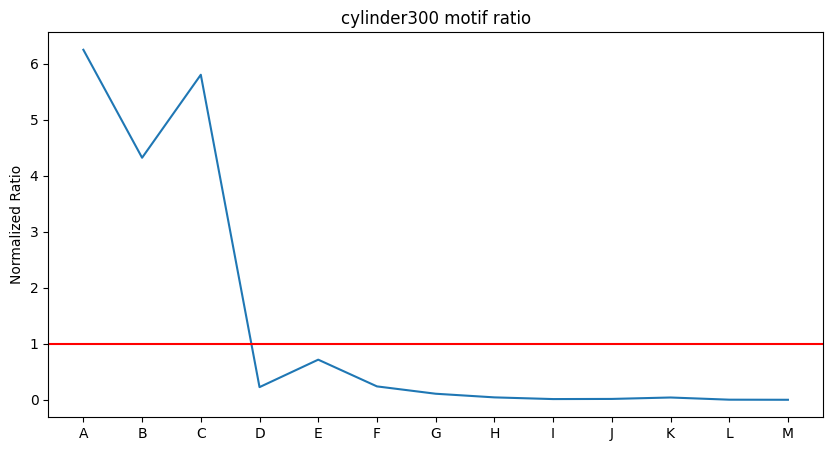

In [107]:
chosen_df = df_ei.ratio[3:]
chosen_df.plot(figsize=(10,5),title=f'{nodeset} motif ratio')
# plot all xticklabels
plt.xticks(np.arange(len(df_ei)-3), df_ei.index[3:])
# horizontal line at y=1
plt.axhline(y=1, color='r', linestyle='-')
plt.ylabel('Normalized Ratio')
plt.savefig(f'{save_dir}/{nodeset}_triplet_ratios_EI.pdf',dpi=300)
plt.show()

# chosen_df.plot(figsize=(10,5),title=f'{nodeset} motif ratio')
# # plot all xticklabels
# plt.xticks(np.arange(len(df_ei)-3), df_ei.index[3:])
# # horizontal line at y=1
# plt.yscale('log')
# plt.axhline(y=1, color='r', linestyle='-')
# plt.ylabel('Normalized Ratio')
# # plt.savefig(f'{save_dir}/{target}_triplet_ratios_EI_log.png',dpi=300)
# plt.show()


In [ ]:
chosen_df = df_ei.ratio_norm[3:]
chosen_df.plot(figsize=(10,5),title=f'{target} motif ratio')
# plot all xticklabels
plt.xticks(np.arange(len(df_ei)-3), df_ei.index[3:])
# horizontal line at y=1
plt.axhline(y=1, color='r', linestyle='-')
plt.ylabel('Normalized Ratio')
plt.show()
plt.savefig(f'{save_dir}/{target}_motif_ratio_EI.png')

chosen_df.plot(figsize=(10,5),title=f'{target} motif ratio')
# plot all xticklabels
plt.xticks(np.arange(len(df_ei)-3), df_ei.index[3:])
# horizontal line at y=1
plt.yscale('log')
plt.axhline(y=1, color='r', linestyle='-')
plt.ylabel('Normalized Ratio')
plt.show()


# CA1 Perisomatic INT: Distal INT

In [77]:
selected_nodesets = ['SP_AA','BC']
selected_ids = np.concatenate([nodes.ids(i) for i in selected_nodesets])

In [79]:
np.unique(nodes.get(selected_ids).mtype)

array(['SP_AA', 'SP_CCKBC', 'SP_PVBC'], dtype=object)

In [80]:
perisomatic_nodeset_ids = np.intersect1d(nodeset_ids,selected_ids) # to be changed for each, union operator if multiple mtypes
local_indices_selected = np.where(np.isin(nodeset_ids,perisomatic_nodeset_ids))[0] # indices inside nodeset indices
perisomatic_adj = target_adj[local_indices_selected,:][:,local_indices_selected]
perisomatic_adj[perisomatic_adj>1] = 1  # connectome
perisomatic_target_graph = nx.from_scipy_sparse_array(perisomatic_adj,create_using=nx.DiGraph())
Executor = GrandIsoExecutor(graph=perisomatic_target_graph)

In [81]:
frequencies_perisomatic = {}

for motif_name in tqdm(all_motifs):
    logging.info(f"Running motif calculation for {nodeset} of motif {motif_name} of {selected_nodesets}...")
    CM = motif_reader.name_to_matrix(motif_name)
    cur_triplet_motif = reader.matrix_to_dotmotif(CM)
    if cur_triplet_motif == '':
        continue
    else:
        logging.info(f"\n{CM} \n\n dotmotif:\n{cur_triplet_motif}\n\n")
        cur_triplet_motif = Motif(cur_triplet_motif)

    cur_results = Executor.find(cur_triplet_motif)
    frequencies_perisomatic[motif_name] = cur_results

  0%|          | 0/16 [00:00<?, ?it/s]INFO:root:Running motif calculation for cylinder300 of motif -C of ['SP_AA', 'BC']...
INFO:root:Running motif calculation for cylinder300 of motif -B of ['SP_AA', 'BC']...
INFO:root:
[[0 1 0]
 [0 0 0]
 [0 0 0]] 

 dotmotif:
A -> B


 12%|█▎        | 2/16 [00:00<00:00, 14.58it/s]INFO:root:Running motif calculation for cylinder300 of motif -A of ['SP_AA', 'BC']...
INFO:root:
[[0 1 0]
 [1 0 0]
 [0 0 0]] 

 dotmotif:
A -> B
B -> A


INFO:root:Running motif calculation for cylinder300 of motif A of ['SP_AA', 'BC']...
INFO:root:
[[0 0 0]
 [1 0 0]
 [1 0 0]] 

 dotmotif:
B -> A
C -> A


 25%|██▌       | 4/16 [00:17<01:01,  5.13s/it]INFO:root:Running motif calculation for cylinder300 of motif B of ['SP_AA', 'BC']...
INFO:root:
[[0 0 0]
 [1 0 0]
 [0 1 0]] 

 dotmotif:
B -> A
C -> B


 31%|███▏      | 5/16 [00:30<01:20,  7.34s/it]INFO:root:Running motif calculation for cylinder300 of motif C of ['SP_AA', 'BC']...
INFO:root:
[[0 0 0]
 [1 0 1]
 [0 0 0]] 

 dotm

In [82]:
#SAVE 

target_motifs_perisomatic = {}
for i in all_motifs:
    try:
        cur_occurences = len(frequencies_perisomatic[i])
        target_motifs_perisomatic[i] = cur_occurences
    except:
        print(f'{i} not in frequencies')
        target_motifs_perisomatic[i] = -1

-C not in frequencies


In [83]:
target_motifs_perisomatic

{'-C': -1,
 '-B': 16045,
 '-A': 6116,
 'A': 1016442,
 'B': 934745,
 'C': 1123706,
 'D': 382805,
 'E': 379719,
 'F': 418214,
 'G': 271887,
 'H': 176944,
 'I': 166854,
 'J': 152165,
 'K': 186286,
 'L': 86120,
 'M': 49716}

# Distal INHs

In [87]:
perisomatic_mtypes = ['SP_AA','BC']
perisomatic_ids = np.concatenate([nodes.ids(i) for i in perisomatic_mtypes])

In [88]:
inhibitory_ids = nodes.ids('Inhibitory')

In [90]:
distal_inh_ids = np.setdiff1d(inhibitory_ids,perisomatic_ids)

In [91]:
distal_nodeset_ids = np.intersect1d(nodeset_ids,distal_inh_ids) # to be changed for each, union operator if multiple mtypes
local_indices_selected = np.where(np.isin(nodeset_ids,distal_nodeset_ids))[0] # indices inside nodeset indices
distal_adj = target_adj[local_indices_selected,:][:,local_indices_selected]
distal_adj[distal_adj>1] = 1  # connectome
distal_target_graph = nx.from_scipy_sparse_array(distal_adj,create_using=nx.DiGraph())
Executor = GrandIsoExecutor(graph=distal_target_graph)

In [92]:
frequencies_distal = {}

for motif_name in tqdm(all_motifs):
    logging.info(f"Running motif calculation for {nodeset} of motif {motif_name} of Distal INHs ...")
    CM = motif_reader.name_to_matrix(motif_name)
    cur_triplet_motif = reader.matrix_to_dotmotif(CM)
    if cur_triplet_motif == '':
        continue
    else:
        logging.info(f"\n{CM} \n\n dotmotif:\n{cur_triplet_motif}\n\n")
        cur_triplet_motif = Motif(cur_triplet_motif)

    cur_results = Executor.find(cur_triplet_motif)
    frequencies_distal[motif_name] = cur_results

  0%|          | 0/16 [00:00<?, ?it/s]INFO:root:Running motif calculation for cylinder300 of motif -C of Distal INHs ...
INFO:root:Running motif calculation for cylinder300 of motif -B of Distal INHs ...
INFO:root:
[[0 1 0]
 [0 0 0]
 [0 0 0]] 

 dotmotif:
A -> B


 12%|█▎        | 2/16 [00:00<00:01, 10.23it/s]INFO:root:Running motif calculation for cylinder300 of motif -A of Distal INHs ...
INFO:root:
[[0 1 0]
 [1 0 0]
 [0 0 0]] 

 dotmotif:
A -> B
B -> A


INFO:root:Running motif calculation for cylinder300 of motif A of Distal INHs ...
INFO:root:
[[0 0 0]
 [1 0 0]
 [1 0 0]] 

 dotmotif:
B -> A
C -> A


 25%|██▌       | 4/16 [00:39<02:17, 11.49s/it]INFO:root:Running motif calculation for cylinder300 of motif B of Distal INHs ...
INFO:root:
[[0 0 0]
 [1 0 0]
 [0 1 0]] 

 dotmotif:
B -> A
C -> B


 31%|███▏      | 5/16 [01:07<03:02, 16.60s/it]INFO:root:Running motif calculation for cylinder300 of motif C of Distal INHs ...
INFO:root:
[[0 0 0]
 [1 0 1]
 [0 0 0]] 

 dotmotif:
B -> A
B -> 

In [93]:
#SAVE 

target_motifs_distal = {}
for i in all_motifs:
    try:
        cur_occurences = len(frequencies_distal[i])
        target_motifs_distal[i] = cur_occurences
    except:
        print(f'{i} not in frequencies')
        target_motifs_distal[i] = -1

-C not in frequencies


In [ ]:
# check_mtypes = ['PeriSomatic_INH','PeriSomatic_INH','PeriSomatic_INH']
# compare_to = ['Distal_INH','Distal_INH','Distal_INH']

# target_motifs_perisomatic = {}
# target_motifs_distal = {}

# for motif_name in tqdm(all_motifs):
#     logging.info(f"Running motif calculation for {target} of motif {motif_name} of {check_mtypes}...")
#     motif_reader = MotifReader()
#     CM = motif_reader.name_to_matrix(motif_name)
#     # logging.info(f"Motif matrix:\n{CM}")
#     calculator = CA1MotifCalculator(target,check_mtypes, CM)
#     num_motifs = calculator.count_motifs()  # proj samples not used for local computations

#     logging.info(f"Running motif calculation for {target} of motif {motif_name} of {compare_to}...")

#     calculator2 = CA1MotifCalculator(target,compare_to, CM)
#     num_motifs2 = calculator2.count_motifs()  # proj samples not used for local computations

#     target_motifs_perisomatic[motif_name] = num_motifs
#     target_motifs_distal[motif_name] = num_motifs2

In [98]:
df1 = pd.DataFrame.from_dict(target_motifs_perisomatic, orient='index',columns=[f'{nodeset}_perisomatic'])
df2 = pd.DataFrame.from_dict(target_motifs_distal, orient='index',columns=[f'{nodeset}_distal'])

df_peridistal = pd.concat([df1,df2],axis=1)
df_peridistal['ratio'] = df_peridistal[f'{nodeset}_perisomatic']/df_peridistal[f'{nodeset}_distal']
df_peridistal.to_csv(f'{save_dir}/{nodeset}_triplet_ratios_peridistal.csv')

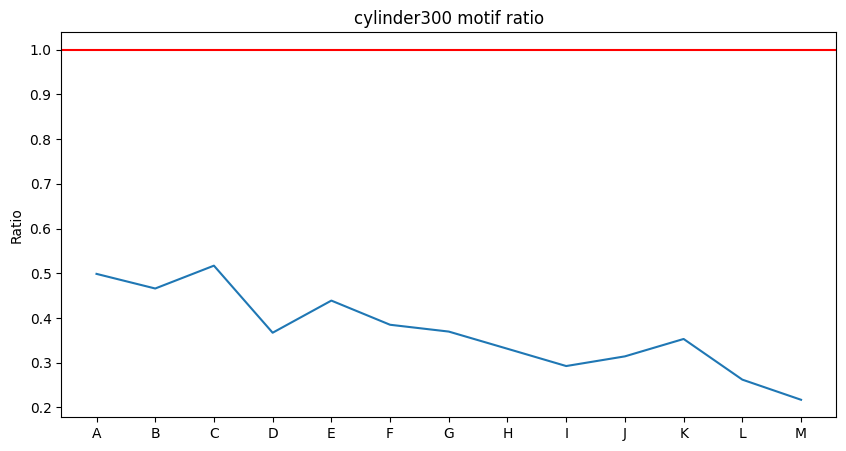

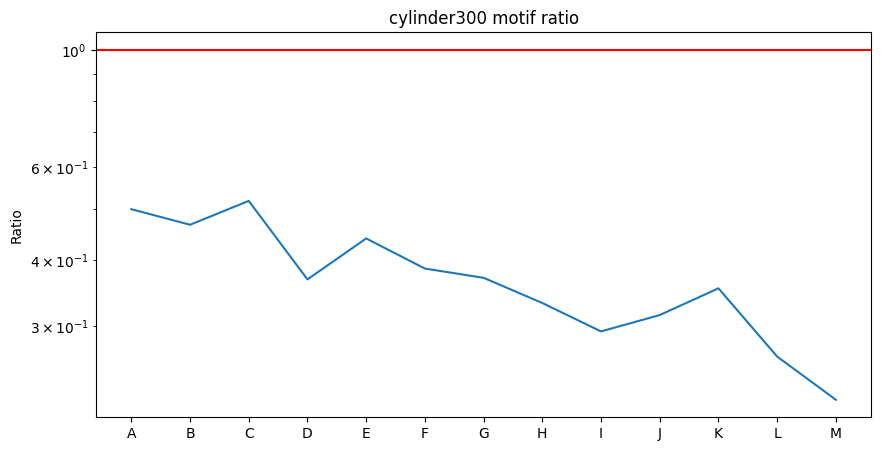

In [109]:
chosen_df = df_peridistal.ratio[3:]
chosen_df.plot(figsize=(10,5),title=f'{nodeset} motif ratio')
# plot all xticklabels
plt.xticks(np.arange(len(df_peridistal)-3), df_peridistal.index[3:])
# horizontal line at y=1
plt.axhline(y=1, color='r', linestyle='-')
plt.ylabel('Ratio')
plt.savefig(f'{save_dir}/{nodeset}_triplet_ratios_peridistal.pdf',dpi=300)
plt.show()

chosen_df.plot(figsize=(10,5),title=f'{nodeset} motif ratio')
# plot all xticklabels
plt.xticks(np.arange(len(df_peridistal)-3), df_peridistal.index[3:])
# horizontal line at y=1
plt.yscale('log')
plt.axhline(y=1, color='r', linestyle='-')
plt.ylabel('Ratio')
plt.savefig(f'{save_dir}/{nodeset}_triplet_ratios_peridistal_log.pdf',dpi=300)
plt.show()


# Combined figure 7D

In [101]:
df_ei = pd.read_csv(f'{save_dir}/{nodeset}_triplet_ratios_EI.csv',index_col=0)
df_peridistal = pd.read_csv(f'{save_dir}/{nodeset}_triplet_ratios_peridistal.csv',index_col=0)

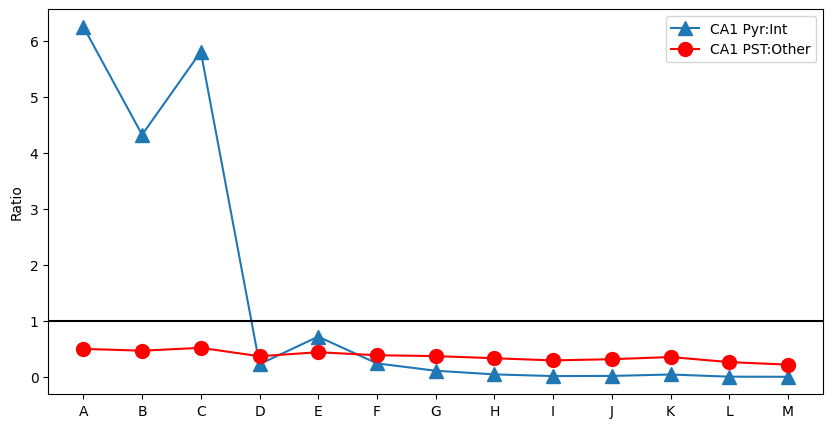

In [110]:
chosen_df1 = df_ei.ratio[3:]
# chosen_df1.plot(figsize=(10,5),title=f'{target} motif ratio')
# add black triangles and blue lines connecting for every point in the plot and lines
chosen_df1.plot(style='^-',ms=10,figsize=(10,5))

chosen_df2= df_peridistal.ratio[3:]
chosen_df2.plot(style='o-r',ms=10,figsize=(10,5))


# plot all xticklabels
plt.xticks(np.arange(len(df_peridistal)-3), df_peridistal.index[3:])
# horizontal line at y=1
plt.axhline(y=1, color='k', linestyle='-')
plt.ylabel('Ratio')
plt.legend(['CA1 Pyr:Int','CA1 PST:Other'])
plt.savefig(f'{save_dir}/{nodeset}_Rees2016_Fig7D.pdf',dpi=300)
plt.show()
